# Imported Packages

In [1]:
import numpy as np
import pandas as pd
from pandas_datareader import data
import matplotlib.pyplot as plt
%matplotlib inline

## Reading Data

In [3]:
test = data.DataReader(['TSLA', 'FB'], 'yahoo', start='2018/01/01', end='2019/12/31')

#Obtaining the closing price [Always use adjusted closing price]
test = test['Adj Close']
test.head()

Symbols,TSLA,FB
Date,,
2018-01-02,64.106003,181.419998
2018-01-03,63.450001,184.669998
2018-01-04,62.924000,184.330002
2018-01-05,63.316002,186.850006
2018-01-08,67.281998,188.279999


### Tesla

In [8]:
tesla = test['TSLA'].pct_change().apply(lambda x: np.log(1+x)) #Percentage change (pct_change) is only the arthimetic returns. To obtain the log returns we use the function ln(1+artimatic returns)
tesla.head()

Date
2018-01-02         NaN
2018-01-03   -0.010286
2018-01-04   -0.008325
2018-01-05    0.006210
2018-01-08    0.060755
Name: TSLA, dtype: float64

#### Variance

In [10]:
var_tesla = tesla.var()
var_tesla

0.0011483734269334606

### Facebook

In [11]:
fb = test['FB'].pct_change().apply(lambda x: np.log(1+x))
fb.head()

Date
2018-01-02         NaN
2018-01-03    0.017756
2018-01-04   -0.001843
2018-01-05    0.013579
2018-01-08    0.007624
Name: FB, dtype: float64

#### Variance

In [12]:
var_fb = fb.var()
var_fb

0.0004569725841702254

## Volatility
We multiply the SD by 250 because of a standard of 250 trading days. This then makes the SD interms of annual rather than daily

In [13]:
# Volatility
tesla_vol = np.sqrt(var_tesla * 250)
fb_vol = np.sqrt(var_fb * 250)
tesla_vol, fb_vol

(0.5358109337568292, 0.33799873674698305)

<AxesSubplot:xlabel='Symbols'>

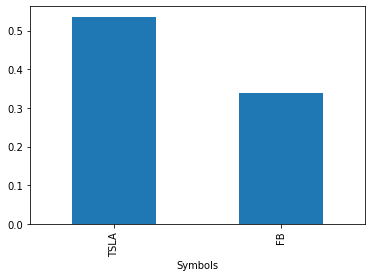

In [14]:
test.pct_change().apply(lambda x: np.log(1+x)).std().apply(lambda x: x*np.sqrt(250)).plot(kind='bar')

## Testing Covaraince

In [15]:
test1 = test.pct_change().apply(lambda x: np.log(1+x))
test1.head()

Symbols,TSLA,FB
Date,,
2018-01-02,NaN,NaN
2018-01-03,-0.010286,0.017756
2018-01-04,-0.008325,-0.001843
2018-01-05,0.006210,0.013579
2018-01-08,0.060755,0.007624


In [19]:
test1['TSLA'].cov(test1['FB'])

0.0001826162315603096

## Testing Correlation

In [20]:
test1['TSLA'].corr(test1['FB'])


0.2520883272466129

# Optimized Risky Portfolio

In [22]:
df = data.DataReader(['AAPL', 'NKE', 'GOOGL', 'AMZN'], 'yahoo', start='2015/01/01', end='2019/12/31')
df = df['Adj Close']
df.head()

Symbols,AAPL,NKE,GOOGL,AMZN
Date,,,,
2014-12-31,24.915258,44.524044,530.659973,310.350006
2015-01-02,24.678257,44.005405,529.549988,308.519989
2015-01-05,23.983025,43.296913,519.460022,302.190002
2015-01-06,23.985281,43.042233,506.640015,295.290009
2015-01-07,24.321604,43.931309,505.149994,298.420013


## Using a Covariance and Correlation matrix

In [23]:
cov_matrix = df.pct_change().apply(lambda x: np.log(1+x)).cov()
cov_matrix

Symbols,AAPL,NKE,GOOGL,AMZN
Symbols,,,,
AAPL,0.000245,0.000084,0.000122,0.000142
NKE,0.000084,0.000219,0.000085,0.000092
GOOGL,0.000122,0.000085,0.000221,0.000176
AMZN,0.000142,0.000092,0.000176,0.000333


In [24]:
corr_matrix = df.pct_change().apply(lambda x: np.log(1+x)).corr()
corr_matrix

Symbols,AAPL,NKE,GOOGL,AMZN
Symbols,,,,
AAPL,1.000000,0.361188,0.524818,0.496704
NKE,0.361188,1.000000,0.387448,0.341680
GOOGL,0.524818,0.387448,1.000000,0.647952
AMZN,0.496704,0.341680,0.647952,1.000000


## Applying resampling to the data to make them in yearly data

In [25]:
ind_er = df.resample('Y').last().pct_change().mean()
ind_er

Symbols
AAPL     0.282997
NKE      0.192698
GOOGL    0.217545
AMZN     0.472289
dtype: float64

In [26]:
ann_sd = df.pct_change().apply(lambda x: np.log(1+x)).std().apply(lambda x: x*np.sqrt(250))
ann_sd

Symbols
AAPL     0.247734
NKE      0.233803
GOOGL    0.235191
AMZN     0.288559
dtype: float64

In [27]:
assets = pd.concat([ind_er, ann_sd], axis=1) # Creating a table for visualising returns and volatility of assets
assets.columns = ['Returns', 'Volatility']
assets

,Returns,Volatility
Symbols,,
AAPL,0.282997,0.247734
NKE,0.192698,0.233803
GOOGL,0.217545,0.235191
AMZN,0.472289,0.288559


## Creating a lopop of random values to create multiple instances of weights

In [28]:
p_ret = [] # Define an empty array for portfolio returns
p_vol = [] # Define an empty array for portfolio volatility
p_weights = [] # Define an empty array for asset weights

In [29]:
num_assets = len(df.columns)
num_portfolios = 10000

In [46]:
for portfolio in range(num_portfolios):
    weights = np.random.random(num_assets)
    weights = weights/np.sum(weights)
    p_weights.append(weights)
    returns = np.dot(weights, ind_er) # Returns are the product of individual expected returns of asset and its 
                                      # weights 
    p_ret.append(returns)
    var = cov_matrix.mul(weights, axis=0).mul(weights, axis=1).sum().sum()# Portfolio Variance
    sd = np.sqrt(var) # Daily standard deviation
    ann_sd = sd*np.sqrt(250) # Annual standard deviation = volatility
    p_vol.append(ann_sd)

## Compiling the data

In [47]:
data = {'Returns':p_ret, 'Volatility':p_vol}

for counter, symbol in enumerate(df.columns.tolist()):
    data[symbol+' weight'] = [w[counter] for w in p_weights]

In [48]:
portfolios  = pd.DataFrame(data)
portfolios.head() # Dataframe of the 10000 portfolios created

,Returns,Volatility,AAPL weight,NKE weight,GOOGL weight,AMZN weight
0,0.259541,0.191119,0.266113,0.510940,0.076628,0.146319
1,0.263758,0.188340,0.232161,0.398215,0.209024,0.160599
2,0.287587,0.198641,0.056220,0.314607,0.337979,0.291194
3,0.242238,0.191440,0.198836,0.259903,0.470064,0.071198
4,0.315785,0.207953,0.059465,0.227134,0.320882,0.392518


<AxesSubplot:xlabel='Volatility', ylabel='Returns'>

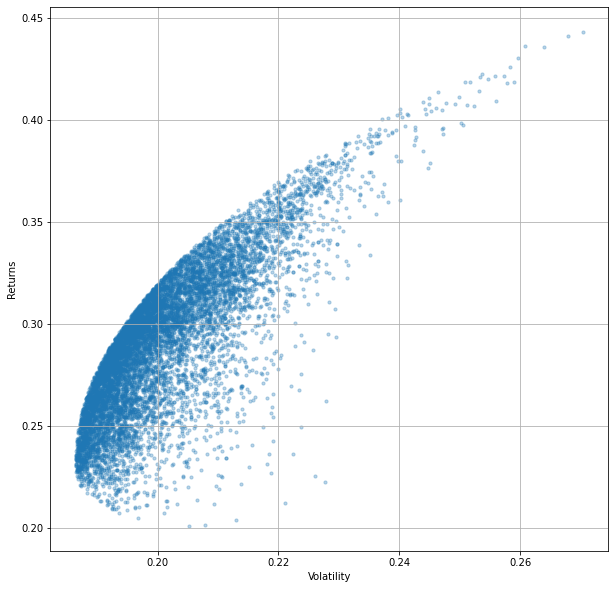

In [49]:
portfolios.plot.scatter(x='Volatility', y='Returns', marker='o', s=10, alpha=0.3, grid=True, figsize=[10,10])

## Minimum risk portfolio

In [50]:
min_vol_port = portfolios.iloc[portfolios['Volatility'].idxmin()]
# idxmin() gives us the minimum value in the column specified.                               
min_vol_port
#Return index of first occurrence of minimum over requested axis. NA/null values are excluded.

Returns         0.233995
Volatility      0.186478
AAPL weight     0.256271
NKE weight      0.410757
GOOGL weight    0.294179
AMZN weight     0.038793
Name: 2001, dtype: float64

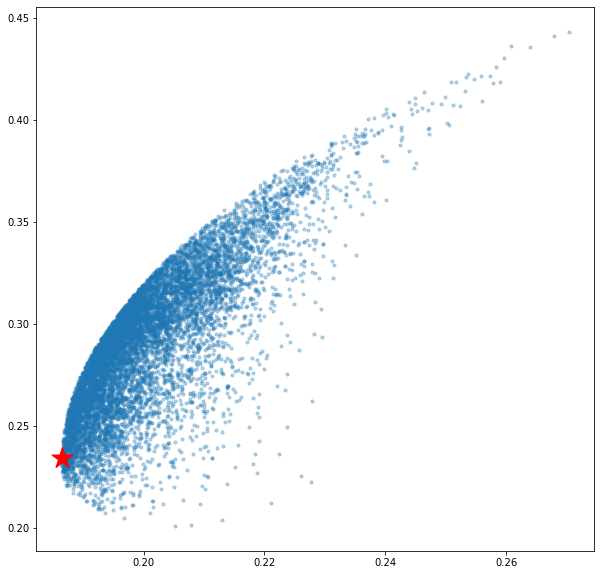

In [51]:
plt.subplots(figsize=[10,10])
plt.scatter(portfolios['Volatility'], portfolios['Returns'],marker='o', s=10, alpha=0.3)
plt.scatter(min_vol_port[1], min_vol_port[0], color='r', marker='*', s=500)

## Optimal Risky Portfolio

In [52]:
rf = 0.01 # risk factor #Risk free rate
optimal_risky_port = portfolios.iloc[((portfolios['Returns']-rf)/portfolios['Volatility']).idxmax()]
optimal_risky_port

Returns         0.400621
Volatility      0.237216
AAPL weight     0.237868
NKE weight      0.088985
GOOGL weight    0.006918
AMZN weight     0.666229
Name: 3567, dtype: float64

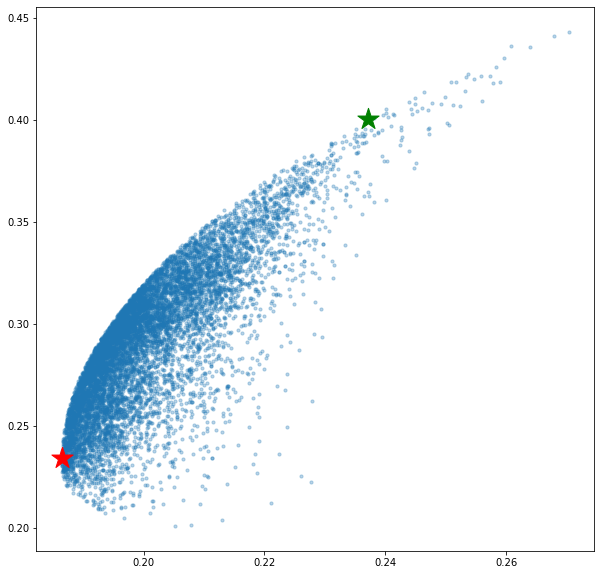

In [53]:
plt.subplots(figsize=(10, 10))
plt.scatter(portfolios['Volatility'], portfolios['Returns'],marker='o', s=10, alpha=0.3)
plt.scatter(min_vol_port[1], min_vol_port[0], color='r', marker='*', s=500)
plt.scatter(optimal_risky_port[1], optimal_risky_port[0], color='g', marker='*', s=500)